## Resources
https://www.quantinsti.com/blog/artificial-neural-network-python-using-keras-predicting-stock-price-movement?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html



In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)

def load_data(fpath, dropna=True):
    df = pd.read_csv(fpath)
    if dropna:
        df = df.dropna()
    df = df[['Date', 'Close']]
    df['Month'] = df['Date'].map(lambda x: int(x.split('/')[0]))
    df['Day'] = df['Date'].map(lambda x: int(x.split('/')[1]))

    df['Month_sin'] = np.sin((df.Month-1)*(2*np.pi/12))
    df['Month_cos'] = np.cos((df.Month-1)*(2*np.pi/12))

    df['Day_sin'] = np.sin((df.Day-1)*(2*np.pi/31))
    df['Day_cos'] = np.cos((df.Day-1)*(2*np.pi/31))
    return df

def add_features(df):
    df['3day MA'] = df['Close'].rolling(window = 3).mean()
    df['10day MA'] = df['Close'].rolling(window = 10).mean()
    df['30day MA'] = df['Close'].rolling(window = 30).mean()
    df['Std_dev']= df['Close'].rolling(5).std()
    
    df = df.dropna()
    return df


In [105]:
company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
fpath = './Data Given/' + company_files[1]
df = load_data(fpath)
df = add_features(df)
print(df.head(5))

         Date      Close  Month  Day  Month_sin  Month_cos   Day_sin  \
29  2/13/2009  31.518396      2   13        0.5   0.866025  0.651372   
30  2/17/2009  29.783264      2   17        0.5   0.866025 -0.101168   
31  2/18/2009  28.877563      2   18        0.5   0.866025 -0.299363   
32  2/19/2009  28.820360      2   19        0.5   0.866025 -0.485302   
33  2/20/2009  27.495176      2   20        0.5   0.866025 -0.651372   

     Day_cos    3day MA   10day MA   30day MA   Std_dev  
29 -0.758758  30.863749  30.933981  31.554624  0.704798  
30 -0.994869  30.561849  30.877732  31.445940  0.627582  
31 -0.954139  30.059741  30.744260  31.312786  0.990059  
32 -0.874347  29.160396  30.542146  31.128150  1.126417  
33 -0.758758  28.397700  30.191306  30.949870  1.484985  


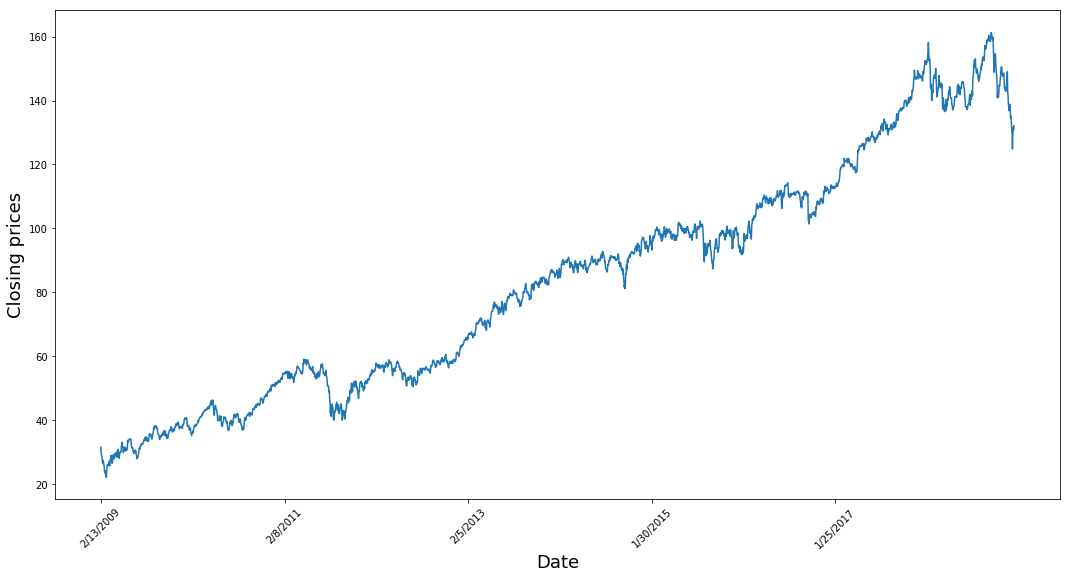

In [106]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing prices', fontsize=18)
plt.show()

In [107]:
input_features = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

split_idx = int(0.9*len(input_features))
train_data = input_features[:split_idx]
test_data = input_features[split_idx:]

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
test_set_scaled = sc.transform(test_data)


In [108]:
def get_X_Y_train(training_set_scaled, chunk_size=45):
    X_train = []
    Y_train = []

    for i in range(chunk_size, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-chunk_size:i])
        Y_train.append(training_set_scaled[i, 0])

    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    return X_train, Y_train


In [109]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def fit_model(X_train, Y_train, epochs=3):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50, return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.4))

    model.add(Dense(units=1))

    # Could experiment using root_mean_squared error
    model.compile(optimizer='adam', loss="mean_squared_error")

    model.fit(X_train, Y_train, epochs=epochs, batch_size=32)
    return model
          

In [110]:
X_train, Y_train = get_X_Y_train(training_set_scaled)
model = fit_model(X_train, Y_train)

Epoch 1/3
2193/2193 [==============================] - 23s 10ms/step - loss: 0.0231
Epoch 2/3
2193/2193 [==============================] - 16s 7ms/step - loss: 0.0071
Epoch 3/3
2193/2193 [==============================] - 16s 7ms/step - loss: 0.0056


In [111]:
def predict_stock_prices(total_data, chunk_size, num_days, num_trailing_blanks, sc, model):
    predicted_stock_prices = []

    for day in range(num_days):
        curr_idx = len(total_data) - num_trailing_blanks + day

        start_idx = len(total_data) - num_trailing_blanks - chunk_size + day
        end_idx = start_idx+chunk_size
        inputs = total_data[start_idx:end_idx]
        X_test = []
        X_test.append(inputs)

        X_test = np.array(X_test)
        predicted_stock_price = model.predict(X_test)
        
        print("Before")
        print(total_data[curr_idx-2:curr_idx+1])
        total_data[curr_idx][0] = predicted_stock_price
        print('Predicted stock price: ', predicted_stock_price)
        total_data[curr_idx][5] = total_data[curr_idx-2:curr_idx+1, 0].mean()
        total_data[curr_idx][6] = total_data[curr_idx-9:curr_idx+1, 0].mean()
        total_data[curr_idx][7] = total_data[curr_idx-29:curr_idx+1, 0].mean()
        total_data[curr_idx][8] = total_data[curr_idx-4:curr_idx+1, 0].std()
        print("After")
        print(total_data[curr_idx-2:curr_idx+1])


        predicted_stock_price = sc.inverse_transform(total_data[curr_idx].reshape(1, -1))[0][0]
        predicted_stock_prices.append(predicted_stock_price)
        
    return predicted_stock_prices

In [112]:
num_days = 50
total_data = np.concatenate((training_set_scaled, test_set_scaled))
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(test_set_scaled), sc=sc, model=model)

Before
[[0.98306401 0.5        1.         0.60077861 0.98973865 0.99255901
  0.99838879 0.9984248  0.04878975]
 [0.97350463 0.5        1.         0.69743133 0.95937469 0.98826714
  0.99672337 1.         0.12685603]
 [0.9890104  0.5        1.         0.78600119 0.91015123 0.99116224
  0.99702547 1.00173669 0.15213864]]
Predicted stock price:  [[0.9716489]]
After
[[0.98306401 0.5        1.         0.60077861 0.98973865 0.99255901
  0.99838879 0.9984248  0.04878975]
 [0.97350463 0.5        1.         0.69743133 0.95937469 0.98826714
  0.99672337 1.         0.12685603]
 [0.97164887 0.5        1.         0.78600119 0.91015123 0.97607251
  0.98184723 0.97921853 0.00556777]]
Before
[[0.97350463 0.5        1.         0.69743133 0.95937469 0.98826714
  0.99672337 1.         0.12685603]
 [0.97164887 0.5        1.         0.78600119 0.91015123 0.97607251
  0.98184723 0.97921853 0.00556777]
 [0.99713969 0.5        1.         0.86286212 0.84408348 0.99591126
  0.99768389 1.00338601 0.23371135]]
Pre

Before
[[0.9504227  0.75       0.9330127  0.96947864 0.67281328 0.95297299
  0.95730087 0.9646716  0.00301629]
 [0.94759911 0.75       0.9330127  0.99486932 0.57462265 0.95036234
  0.95618559 0.96347689 0.00349342]
 [0.93933152 0.75       0.9330127  1.         0.47332431 0.95169707
  1.00113095 1.02584379 0.46583341]]
Predicted stock price:  [[0.94469583]]
After
[[0.9504227  0.75       0.9330127  0.96947864 0.67281328 0.95297299
  0.95730087 0.9646716  0.00301629]
 [0.94759911 0.75       0.9330127  0.99486932 0.57462265 0.95036234
  0.95618559 0.96347689 0.00349342]
 [0.94469583 0.75       0.9330127  1.         0.47332431 0.94757255
  0.95471377 0.96213774 0.00381246]]
Before
[[0.94759911 0.75       0.9330127  0.99486932 0.57462265 0.95036234
  0.95618559 0.96347689 0.00349342]
 [0.94469583 0.75       0.9330127  1.         0.47332431 0.94757255
  0.95471377 0.96213774 0.00381246]
 [0.95114905 0.75       0.9330127  0.895896   0.19187389 0.94732899
  0.99183551 1.0246101  0.45714142]]
Pr

Before
[[0.92733216 0.9330127  0.75       1.         0.47332431 0.92937799
  0.9338008  0.9424029  0.00263001]
 [0.92519927 0.9330127  0.75       0.895896   0.19187389 0.92731529
  0.93272197 0.94126241 0.0028323 ]
 [0.96642905 0.9330127  0.75       0.82610479 0.11835923 0.98427996
  0.9707581  0.99386335 0.28528318]]
Predicted stock price:  [[0.9233685]]
After
[[0.92733216 0.9330127  0.75       1.         0.47332431 0.92937799
  0.9338008  0.9424029  0.00263001]
 [0.92519927 0.9330127  0.75       0.895896   0.19187389 0.92731529
  0.93272197 0.94126241 0.0028323 ]
 [0.92336851 0.9330127  0.75       0.82610479 0.11835923 0.92529998
  0.93140549 0.94004377 0.00286496]]
Before
[[0.92519927 0.9330127  0.75       0.895896   0.19187389 0.92731529
  0.93272197 0.94126241 0.0028323 ]
 [0.92336851 0.9330127  0.75       0.82610479 0.11835923 0.92529998
  0.93140549 0.94004377 0.00286496]
 [0.95829977 0.9330127  0.75       0.74296282 0.06041634 0.97465489
  0.97022361 0.99159983 0.28474567]]
Pre

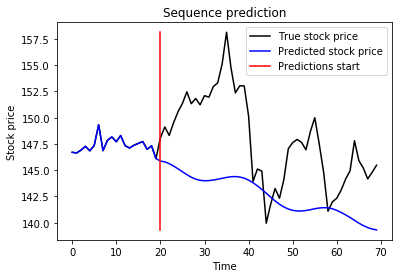

[145.86971842919579, 145.79685791474571, 145.62288825722231, 145.39226954971397, 145.12737604186643, 144.84900333884562, 144.57677824173155, 144.32835424600447, 144.14822180330052, 144.03668449909654, 143.99122257393446, 144.00587057319368, 144.05989360880363, 144.13859055404666, 144.22751074022344, 144.31182401678862, 144.37721632850756, 144.39163663865915, 144.34749531032148, 144.23910011580313, 144.05767743482247, 143.80465411912073, 143.50340625041736, 143.16692728712263, 142.8073910068592, 142.43770738203122, 142.0710672016089, 141.75432129431107, 141.49603077058555, 141.30160704155767, 141.17350914959016, 141.11450731215945, 141.1149475111009, 141.16034871916762, 141.23676118369713, 141.3288690173811, 141.398344553764, 141.43138224328496, 141.41699229168105, 141.32636443719687, 141.16912992908624, 140.97130604271734, 140.74310083975018, 140.49188385763588, 140.2267398917699, 139.95515232415727, 139.72203662610164, 139.53478510396494, 139.39704837310663, 139.31257571416606]


In [113]:
actual_line = np.concatenate((train_data[-20:, 0], test_data[:num_days, 0]))
predicted_line = np.concatenate((train_data[-20:, 0], predicted_stock_prices))

miny = min(np.min(actual_line), np.min(predicted_line))
maxy = max(np.max(actual_line), np.max(predicted_line))

plt.plot(actual_line, color='black', label='True stock price')
plt.plot(predicted_line, color='blue', label='Predicted stock price')
plt.plot((20, 20), (miny, maxy), 'k-', color='red', label='Predictions start')
plt.title("Sequence prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
print(predicted_stock_prices)

In [114]:
# company_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
# fpath = './Data Given/' + company_files[1]
df = load_data(fpath)
df = add_features(df)

input_data = df[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']].loc[:].values

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(input_data)

chunk_size=45
X_train, Y_train = get_X_Y_train(training_set_scaled, chunk_size=chunk_size)
model = fit_model(X_train, Y_train, epochs=2)



Epoch 1/2
2442/2442 [==============================] - 23s 9ms/step - loss: 0.0258
Epoch 2/2
2442/2442 [==============================] - 17s 7ms/step - loss: 0.0077


In [115]:
df_predict = load_data('./Data Given/submission_template.csv', dropna=False)
df_predict['Close'] = 0.
df_predict['3day MA'] = 0.
df_predict['10day MA'] = 0.
df_predict['30day MA'] = 0.
df_predict['Std_dev'] = 0.

predict_data = df_predict[['Close', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', '3day MA', '10day MA', '30day MA', 'Std_dev']]
predict_data_scaled = sc.transform(predict_data)
# predict_data_scaled = predict_data_scaled.loc[:].values

total_data = np.concatenate((training_set_scaled, predict_data_scaled))

num_days = len(df_predict)
predicted_stock_prices = predict_stock_prices(total_data, chunk_size, num_days, len(predict_data_scaled), sc=sc, model=model)
print(predicted_stock_prices)


# df.to_csv('Team50_Undergrad.csv')

Before
[[ 0.78064709  0.25        0.9330127   0.13713788  0.84408348  0.78188189
   0.79323134  0.86246     0.55054614]
 [ 0.79042196  0.25        0.9330127   0.39922139  0.98973865  0.78802686
   0.79004614  0.85855672  0.61692438]
 [-0.15917781  0.5         1.          0.60077861  0.98973865 -0.16252049
  -0.17714572 -0.19771503 -0.01057415]]
Predicted stock price:  [[0.85079455]]
After
[[0.78064709 0.25       0.9330127  0.13713788 0.84408348 0.78188189
  0.79323134 0.86246    0.55054614]
 [0.79042196 0.25       0.9330127  0.39922139 0.98973865 0.78802686
  0.79004614 0.85855672 0.61692438]
 [0.85079455 0.5        1.         0.60077861 0.98973865 0.80728787
  0.78806436 0.83816308 0.02804126]]
Before
[[ 0.79042196  0.25        0.9330127   0.39922139  0.98973865  0.78802686
   0.79004614  0.85855672  0.61692438]
 [ 0.85079455  0.5         1.          0.60077861  0.98973865  0.80728787
   0.78806436  0.83816308  0.02804126]
 [-0.15917781  0.5         1.          0.69743133  0.95937469 

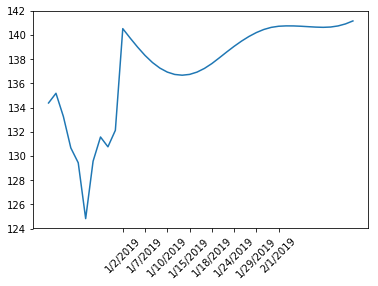

In [116]:
plt.plot(list(input_data[-10:, 0]) + predicted_stock_prices)
plt.xticks(range(10, len(df_predict), 3), df_predict['Date'].loc[::3], rotation=45)
plt.show()